# Outils d'optimisation pour les sciences des données et de la décision - Travaux Pratiques (Correction)

# Master 2 ID 2020-2021

### Clément Royer

*Remarques préliminaires :*

Le polycopié de cours est disponible [ici](https://www.lamsade.dauphine.fr/~croyer/ensdocs/ODD/PolyODD.pdf).

Ce notebook est accessible via [ce lien](https://www.lamsade.dauphine.fr/~croyer/ensdocs/ODD/ODD-TP1-Solutions.ipynb). La version non corrigée est quant à elle disponible [ici](https://www.lamsade.dauphine.fr/~croyer/ensdocs/ODD/ODD-TP1.ipynb).

Ce notebook se base sur la bibliothèque NumPy. Pour un tutoriel (en anglais) sur NumPy, voir
[ici](https://sebastianraschka.com/pdf/books/dlb/appendix_f_numpy-intro.pdf).

Pour tout commentaire sur ce notebook (notamment les typos), merci d'envoyer un mail à **clement.royer@dauphine.psl.eu**.

## I) Introduction

Le but de cette séance de travaux pratiques est d'appliquer différentes méthodes d'optimisation basées sur le gradient à des problèmes de régression. On partira toujours du même jeu de données.

En plus de la partie implémentation, des questions sont disséminées dans le notebook, afin revoir l'ensemble des concepts abordés jusqu'à maintenant dans le cours, notamment :

1) *Convergence et coût d'un algorithme*

2) *Choix de taille de pas*

3) *Accéleration/Momentum*

4) *Régularisation*


In [ ]:
# Bloc préliminaire : appel aux différentes boîtes à outils, bibliothèques, fonctions, etc

%matplotlib inline

from math import sqrt # Racine carrée
import numpy as np # NumPy (calcul scientifique)
from scipy.linalg import norm # Norme euclidienne
import matplotlib.pyplot as plt # Affichage
from numba import njit, jit, jitclass  # Compilation en temps réel pour accélérer l'exécution

### I-A) Génération du jeu de données

On considère un jeu de données $\{(x_i,y_i)\}_{i=1,\dots,n}$ avec $x_i \in \mathbb{R}^d$ et $y_i \in \mathbb{R}$, disponible sous la forme suivante :

- une matrice d'attributs $X \in \mathbb{R}^{n \times d}$;
- un vecteur de labels $y \in \mathbb{R}^n$. 

Ce jeu de données sera généré par la procédure ci-dessous. 
*NB : Cette procédure n'est pas à connaître, elle permet d'introduire suffisamment de bruit pour que les résultats soient interprétables.*

In [ ]:
# Génération des données
#
# Le code ci-dessous est inspiré de celui de A. Gramfort, utilisé dans le cours "Optimization for Machine Learning" 
# donné en Master 2 IASD en 2019-2020.

from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz
    
def simu_linreg(w, n, std=1., corr=0.5):
    
    """
    Simulation d'un problème aux moindres carrés
    
    Paramètres
    ----------
    w : np.ndarray, shape=(d,)
        Coefficients du modèles (variables sur lesquelles optimiser)
    
    n : int
        Taille de l'échantillon
    
    std : float, valeur par défaut=1.
        Ecart-type du bruit

    corr : float, valeur par défaut=0.5
        Corrélation dans la matrice des attributs
    """    
    d = w.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = X.dot(w) + noise
    return X, y

## I-B) Minimisation d'une fonction quadratique convexe/Régression linéaire

Dans le cadre de la *régression linéaire*, on cherche à obtenir un modèle $w$ qui explique au mieux nos données. Pour ce faire, on minimise la fonctionnelle aux moindres carrés suivantes :
$$
    \min_{w \in \mathbb{R}^d} f(w) := \frac{1}{2 n} \|X w - y\|^2 = \frac{1}{n} \sum_{i=1}^n \frac{1}{2}(x_i^T w - y_i)^2.
$$ 

**Question 1 :** *Quelle valeur peut-on utiliser comme minorant de $f$ sur $\mathbb{R}^d$?*

**Réponse 1 :** Toute valeur inférieure ou égale à $0$ est un *minorant* de $f$ car $f$ ne prend que des valeurs positives ou nulles. La valeur $0$ *peut être* l'optimum, mais pas nécessairement; cela ne sera le cas que s'il existe $w^*$ tel que $X w^* = y$.

Le problème ci-dessus peut être reformulé comme un *problème d'optimisation quadratique* de la forme
$$
    \min_{w \in \mathbb{R}^d} \frac{1}{2}w^T A w - b^T w + c.
$$

**Question 2:** *On peut montrer que la matrice $A = \tfrac{X^T X}{n}$ est toujours semi-définie positive, ce qui signifie que la fonction objectif est convexe. Quelle est la propriété des fonctions convexes qui est particulièrement utile pour leur minimisation ?*

**Réponse 2:** Pour une fonction convexe, tout minimum local est un minimum global. Ainsi, une méthode d'optimisation qui converge vers un minimum local convergera de fait vers un minimum global. Pour des fonctions convexes dérivables, cela peut être garanti en convergeant vers un point en lequel le gradient est nul.

Le gradient de la fonction objectif du problème ci-dessous est donné par :
$$
    \nabla f(w) = A w - b = \frac{1}{n}\left( X^T X w - X^T y\right).
$$

### Classe Python pour la régression linéaire

**Question 3:** *Le code ci-dessous définit une classe Python représentant les problèmes de régression linéaire. En utilisant la formule pour le gradient donnée plus haut, compléter ce code ci-dessous pour pouvoir calculer $f(w)$ et $\nabla f(w)$ via des méthodes de la classe.*  

*NOTE: Pour toute matrice (représentée par un tableau NumPy en deux dimensions) X,* X.dot(v)
*renvoie le produit matrice-vecteur $X v$, tandis que* X.T *renvoie la matrice transposée $X^T$.*

In [ ]:
from scipy.linalg import svdvals

# Classe Python pour les problèmes de régression linéaire
class LinReg(object):
   

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
    
    # Fonction objectif
    def fun(self, w):
        return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) 
    
    # Calcul du gradient complet
    def grad(self, w):
        return self.X.T.dot(self.X.dot(w) - self.y) / self.n 

    # Calcul du gradient partiel (correspondant au ième terme de la somme)
    # NB : Ce code ne sera pas utilsé avant la partie IV.
    def grad_i(self, i, w):
        x_i = self.X[i]
        return (x_i.dot(w) - self.y[i]) * x_i 

    # Constante de Lipschitz pour le gradient
    def lipgrad(self):
        L = norm(self.X, ord=2) ** 2 / self.n 
        return L
    
    # Constante de convexité ''forte'' (pourrait être 0 en théorie, ici ce ne sera pas le cas)
    def cvxval(self):
        s = svdvals(self.X)
        mu = min(s)**2 / self.n
        return mu   

### Génération d'une instance de régression linéaire

Le script ci-dessous permet de valider le résultat de la question 3.

In [ ]:
from scipy.optimize import check_grad

d = 50
n = 1000
idx = np.arange(d)

# Coefficients du vrai modèle ("vérité terrain/ground truth")
w_model_truth = (-1)**idx * np.exp(-idx / 10.)

# Calcul du jeu de données
X, y = simu_linreg(w_model_truth, n, std=1., corr=0.1)

# Génération du problème de régression linéaire correspondant
pblinreg = LinReg(X, y)

# Vérification de la valeur du gradient (par comparaison avec une formule de différences finies) 
# La valeur obtenue ne doit pas dépasser 10^(-6) en valeur absolue
check_grad(pblinreg.fun, pblinreg.grad, np.random.randn(d))


1.2858909299189785e-06

## II) Méthode de descente de gradient

On rappelle que l'algorithme de descente de gradient appliqué à une fonction $f$ est défini par un point initial $w_0$ ainsi que par la récursion suivante :

$$
w_{k+1} = w_k - \alpha_k \nabla f(w_k),
$$
où $\alpha_k > 0$ est une taille de pas.

**Question 4:** *Compléter le code ci-dessous pour implémenter l'algorithme de descente de gradient avec trois choix différents de tailles de pas $\{\alpha_k\}_k$:*

**4-a)** *$\alpha_k = \frac{1}{L}$, où $L=\frac{\|X^T X\|}{n}$ est la constante de Lipschitz pour $\nabla f$;*

**4-b)** $\alpha_k = \frac{\alpha_0}{k+1}$;

**4-c)** $\alpha_k = \frac{\alpha_0}{\sqrt{k+1}}$.



In [ ]:
# Implémentation de l'algorithme de descente de gradient
def grad_desc(w0,problem,stepchoice=0,step0=1, n_iter=1000,tol_grad=0.001): 
    """
        Code de la descente de gradient avec différents choix de tailles de pas.
        
        Entrées :
            w0: Point initial
            problem: Problème étudié (instance d'une classe Python)
            stepchoice: Choix de calcul de la taille de pas (voir plus haut)
                0: Taille de pas constante égal à 1/L
                1: Taille de pas décroissante en 1/(k+1)
                2: Taille de pas décroissante en 1/sqrt(k+1)
            step0: Taille de pas initiale (à utiliser lorsque stepchoice>0)
            n_iter: Nombre maximum d'itérations à effectuer
            tol_grad: Tolérance pour la norme du gradient, utilisée comme critère d'arrêt
            
        Sorties :
            w_output: Dernier itéré calculé par l'algorithme
            objvals: Historique des valeurs de fonction (tableau Numpy de longueur au plus n_iter)
            normgrads: Historique des normes du gradient (tableau Numpy de longueur au plus n_iter)
    """
    
    ############
    # Pas initial : Calculer et affichage de quantités initiales

    # Historique des valeurs de fonction
    objvals = []
    # Historique des normes de gradient
    normgrads = []
    
    # Constante de Lipschitz
    L = problem.lipgrad()
    
    # Valeur initiale de l'itéré (le .copy() permet de ne pas modifier le point de départ) 
    w = w0.copy()

    # Initialisation de l'indice d'itération
    k=0    
    
    # Calcul de l'objectif en le point initial+Ajout à l'historique
    obj = problem.fun(w) 
    objvals.append(obj)
    # Calcul de la norme du gradient en le point initial+Ajout à l'historique
    g = problem.grad(w)
    ng = norm(g)
    normgrads.append(ng)

    
    # Affichage des valeurs initiales
    print("Descente de gradient :")
    print(' | '.join([name.center(8) for name in ["iter", "fval", "normg"]]))
    
    print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ng).rjust(8)]))
    
    ###########
    # Boucle principale
    while (k < n_iter and normgrads[k]>tol_grad):
        # Distinction entre les différents choix de pas
        if stepchoice==0:
            w[:] = w - (1/L) * g
        elif stepchoice==1:
            w[:] = w - (step0/(k+1))*g
        else:
            w[:] = w - (step0/(sqrt(k+1)))*g
        # Calcul de l'objectif et de la norme du gradient en le nouveau point
        obj = problem.fun(w)
        objvals.append(obj)
        g = problem.grad(w)
        ng = norm(g)
        normgrads.append(ng)
        k += 1
        # Affichage du nouvel indice d'itération, de la valeur de l'objectif et de la norme du gradient
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ng).rjust(8)]))       
        
    
    w_output = w.copy()
          
    return w_output, np.array(objvals), np.array(normgrads)

In [ ]:
# Ce script permet de valider l'implémentation de la descente de gradient.
w0 = np.zeros(d)
w_a, obj_a, ngrad_a = grad_desc(w0,pblinreg,stepchoice=0,step0=1, n_iter=100,tol_grad=0.001)
w_b, obj_b, ngrad_b = grad_desc(w0,pblinreg,stepchoice=1,step0=1, n_iter=100,tol_grad=0.001)
w_c, obj_c, ngrad_c = grad_desc(w0,pblinreg,stepchoice=2,step0=1, n_iter=100,tol_grad=0.001)

Descente de gradient :
  iter   |   fval   |  normg  
       0 | 2.84e+00 | 2.04e+00
       1 | 9.58e-01 | 8.69e-01
       2 | 5.95e-01 | 4.32e-01
       3 | 5.03e-01 | 2.27e-01
       4 | 4.77e-01 | 1.24e-01
       5 | 4.70e-01 | 6.96e-02
       6 | 4.67e-01 | 3.98e-02
       7 | 4.66e-01 | 2.32e-02
       8 | 4.66e-01 | 1.36e-02
       9 | 4.66e-01 | 8.08e-03
      10 | 4.66e-01 | 4.83e-03
      11 | 4.66e-01 | 2.90e-03
      12 | 4.66e-01 | 1.75e-03
      13 | 4.66e-01 | 1.06e-03
      14 | 4.66e-01 | 6.47e-04
Descente de gradient :
  iter   |   fval   |  normg  
       0 | 2.84e+00 | 2.04e+00
       1 | 6.22e-01 | 5.28e-01
       2 | 5.19e-01 | 2.76e-01
       3 | 4.97e-01 | 2.06e-01
       4 | 4.87e-01 | 1.69e-01
       5 | 4.82e-01 | 1.45e-01
       6 | 4.78e-01 | 1.28e-01
       7 | 4.76e-01 | 1.16e-01
       8 | 4.75e-01 | 1.06e-01
       9 | 4.73e-01 | 9.80e-02
      10 | 4.72e-01 | 9.14e-02
      11 | 4.72e-01 | 8.59e-02
      12 | 4.71e-01 | 8.11e-02
      13 | 4.71e-01 | 7.

**Question 5 :** *Le code ci-dessous affiche une comparaison des différentes variantes selon deux métriques. Quel est l'intérêt de regarder ces deux quantités pour juger de la convergence d'une méthode ?*

**Réponse 5 :**  Une manière de comparer des méthodes consiste à regarder l'évolution de la valeur de la fonction objectif en fonction du nombre d'itérations : on peut ainsi observer si la fonction semble avoir atteint sa valeur minimale, si elle a atteint une valeur cible que l'on s'était fixée, etc. Pour des méthodes telles que la descente de gradient, on peut également regarder l'évolution de la norme du gradient, puisqu'elles visent à calculer un point en lequel le gradient est nul.

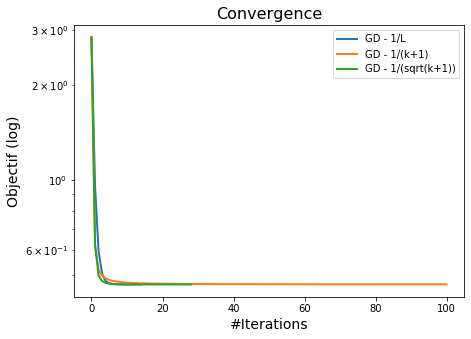

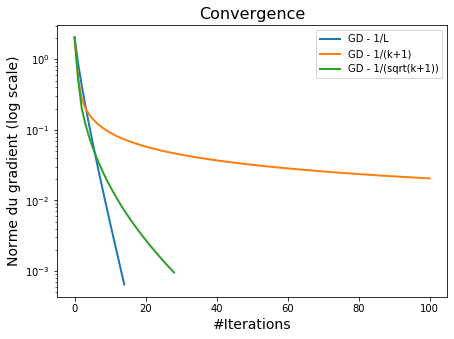

In [ ]:
# Comparaison des trois variantes de descente de gradient

# En termes de fonction objectif (échelle logarithmique sur les deux axes)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a, label="GD - 1/L", lw=2)
plt.semilogy(obj_b, label="GD - 1/(k+1)", lw=2)
plt.semilogy(obj_c, label="GD - 1/(sqrt(k+1))", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objectif (log)", fontsize=14)
plt.legend()
# En termes de norme de gradient (échelle logarithmique sur l'axe des ordonnées)
plt.figure(figsize=(7, 5))
plt.semilogy(ngrad_a, label="GD - 1/L", lw=2)
plt.semilogy(ngrad_b , label="GD - 1/(k+1)", lw=2)
plt.semilogy(ngrad_c, label="GD - 1/(sqrt(k+1))", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Norme du gradient (log scale)", fontsize=14)
plt.legend()

### Questions supplémentaires sur la descente de gradient

**Question 6 :** *Lorsque $L$ est inconnue, on peut déterminer une taille de pas $\alpha_k$ via une recherche linéaire avec retour arrière, ou "bactracking"; on peut ainsi caculer $\alpha_k=\tfrac{1}{2^{j_k}}$ avec $j_k$ le plus petit entier naturel tel que*

$$
f\left(w_k-\frac{1}{2^{j_k}}\nabla f(w_k)\right) < f(w_k) - 0.0001 \frac{1}{2^{j_k}}\|\nabla f(w_k)\|^2.
$$

Cette condition, dite de Armijo-Wolfe, est très fréquemment utilisée en optimisation non linéaire, et remplace l'utilisation de la constante de Lipschitz. Celle-ci est aussi utilisée en apprentissage. On peut montrer que cette condition est vérifiée lorsque $\alpha_k < \frac{1}{2 L}$ lorsque $w_k$ n'est pas un minimum local.

**6-a)** *Pourquoi cette propriété ne peut-elle être vérifiée lorsque $w_k$ est un minimum local ?*

**Réponse 6-a) :** Lorsque $w_k$ est un minimum local, son gradient est nul, et il est alors impossible de vérifier l'inégalité stricte ci-dessus.

**6-b)** *Quel coût supplémentaire induit l'utilisation d'une telle recherche linéaire ?*

**Réponse 6-b):** La technique de recherche linéaire ci-dessus requiert d'évaluer la fonction objectif (potentiellement de manière répétée), ce qui n'est pas le cas d'une descente de gradient où la taille de pas est pré-déterminée *(NB : Dans l'algorithme, nous ne calculions les valeurs de l'objectif que pour pouvoir les afficher plus tard - elles n'interviennent en rien dans le processus d'optimisation, et ne seraient pas calculées en pratique.)* A noter que le coût de calcul des valeurs de fonction peut être compensé par le progrès réalisé en utilisant la valeur de taille de pas calculée.

**Question 7 :** *Pour comparer deux algorithmes (ou deux variantes du même algorithme) on peut regarder l'évolution de la distance entre les itérés et l'ensemble des minima globaux (pour un problème convexe). On peut alors établir des garanties de convergence sur cette distance.*

**7-a)** *Pourquoi ne peut-on pas utiliser ce critère en pratique ?*

**Réponse 7-a) :** En pratique, on ne connaît pas les solutions globales (sinon le problème serait résolu !), et on ne peut donc utiliser ce critère. Celui-ci a tout de même un intérêt théorique.

**7-b)** *Quelle autre mesure impliquant les itérés $w_k$ peut en revanche être employée comme critère d'arrêt ?*

**Réponse 7-b) :** Si les itérés sont très proches les uns des autres, alors cela signifie que la méthode commence à stagner. Dans un code d'optimisation, il est courant de prendre en compte la différence entre deux itérés successifs, et de s'arrêter si celle-ci passe en-dessous d'un seuil acceptable (on parle alors d'*itérés stationnaires*). Dans le cas de l'algorithme de descente de gradient, cela se ramène à regarder la quantité  $\alpha_k \|\nabla f(w_k)\|$ (qui va toujous vers $0$ lorsque le pas est décroissant).

## III) Accélération

On rappelle l'itération de la méthode du gradient accéléré (ou de Nesterov) sous sa forme de double suite.

La méthode part de $z_0=w_0,t_0=0$ et génère deux suites $\{w_{k},z_k\}$ définies par :

$$
    \left\{ 
        \begin{array}{lll}
        w_{k+1} &= &z_k - \alpha_k \nabla f(z_k) \\
        t_{k+1} &= &\tfrac{1}{2} (1+ \sqrt{1+4 t_k^2}) \\
        \beta_{k+1} &= & \frac{t_k-1}{t_{k+1}} \\
        z_{k+1} &= &w_{k+1} + \beta_{k+1}(w_{k+1}-w_k).
        \end{array}
    \right.
$$

Ce méthode possède une vitesse de convergence optimale sur les fonctions convexes.

**Question 8 :** *Implémenter l'algorithme du gradient accéléré avec taille de pas $\alpha_k = \tfrac{1}{L}$ et comparer cette méthode avec l'algorithme de descente du gradient pour le même choix de pas.*

In [ ]:
# Algorithme du gradient accéléré
def accel_grad(w_0,problem, n_iter=1000,tol_grad=0.001,betcst=False): 
    """
        Implémentation de la méthode de Nesterov.
        
        Entrées :
            w0: Point initial
            problem: Problème étudié (instance d'une classe Python)
            n_iter: Nombre maximum d'itérations à effectuer
            tol_grad: Tolérance pour la norme du gradient, utilisée comme critère d'arrêt
            betacst: Choix de calcul pour le paramètre beta_k
                False: beta_k variable (à utiliser en Question 9)
                True: beta_k constant
            
       Sorties :
            z_output: Dernier itéré calculé par l'algorithme
            objvals: Historique des valeurs de fonction (tableau Numpy de longueur au plus n_iter)
            normgrads: Historique des normes du gradient (tableau Numpy de longueur au plus n_iter)
    """
    
    ############
    # Calcul et affichage des quantités initiales

    # Historique des valeurs de l'objectif
    objvals = []
    # Historique des normes de gradient
    normgrads = []
    
    # Constante de Lipschitz
    L = problem.lipgrad()
    
    # Valeur initiale des itérés des deux suites   
    w = w0.copy()
    w_new = w0.copy()
    z = w0.copy()
    
    # Initialisation de la suite t_k utilisée dans le calcul de beta_k variable
    tk = 0
    tkp1 = 1
    
    # Quantités utiles pour le choix de beta
    if not betcst:
        bet = 0
    else:
        mu = problem.cvxval()
        bet = (sqrt(L)-sqrt(mu))/(sqrt(L)+sqrt(mu))
 
    # Initialisation de l'indice des itérations
    k=0
    
    # Calcul de la valeur de l'objectif en le point initial
    obj = problem.fun(w) 
    objvals.append(obj);
    # Calcul de la norme du gradient en l'itéré initial
    g = problem.grad(z)
    ng = norm(g)
    normgrads.append(ng)
    
    print("Gradient Accelere :")
    print(' | '.join([name.center(8) for name in ["iter", "fval", "normg"]]))
    
    print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ng).rjust(8)]))
    
    ###########
    # Boucle principale
    while (k < n_iter and normgrads[k]>tol_grad):
        # Pas de gradient en z
        w_new[:] = z - (1/L) * g
        # Pas de momentum sur w
        z[:] = w_new + bet*(w_new-w)
        # Ajustement de beta si beta non constant
        if not betcst:
            tkp1 = 0.5*(1+sqrt(1+4*(tk**2)))
            bet = (tk-1)/tkp1
            tk = tkp1
        w[:] = w_new[:]
        # Calcul de l'objectif et du gradient en le nouvel itéré z
        obj = problem.fun(z)
        objvals.append(obj)
        g = problem.grad(z)
        ng = norm(g)
        normgrads.append(ng)
        k += 1
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ng).rjust(8)]))       
        
    
    z_output = z.copy()
          
    return z_output, np.array(objvals), np.array(normgrads)

In [ ]:
# Script de test pour comparer la descente de gradient et du gradient accéléré

w0 = np.zeros(d)
w_gd, obj_gd, ngrad_gd = grad_desc(w0,pblinreg,stepchoice=0,step0=1, n_iter=100,tol_grad=0.0001)
z_agd, obj_agd, ngrad_agd = accel_grad(w0,pblinreg, n_iter=100,tol_grad=0.0001,betcst=False)

Descente de gradient :
  iter   |   fval   |  normg  
       0 | 2.84e+00 | 2.04e+00
       1 | 9.58e-01 | 8.69e-01
       2 | 5.95e-01 | 4.32e-01
       3 | 5.03e-01 | 2.27e-01
       4 | 4.77e-01 | 1.24e-01
       5 | 4.70e-01 | 6.96e-02
       6 | 4.67e-01 | 3.98e-02
       7 | 4.66e-01 | 2.32e-02
       8 | 4.66e-01 | 1.36e-02
       9 | 4.66e-01 | 8.08e-03
      10 | 4.66e-01 | 4.83e-03
      11 | 4.66e-01 | 2.90e-03
      12 | 4.66e-01 | 1.75e-03
      13 | 4.66e-01 | 1.06e-03
      14 | 4.66e-01 | 6.47e-04
      15 | 4.66e-01 | 3.94e-04
      16 | 4.66e-01 | 2.41e-04
      17 | 4.66e-01 | 1.48e-04
      18 | 4.66e-01 | 9.06e-05
Gradient Accelere :
  iter   |   fval   |  normg  
       0 | 2.84e+00 | 2.04e+00
       1 | 9.58e-01 | 8.69e-01
       2 | 9.58e-01 | 8.69e-01
       3 | 5.95e-01 | 4.32e-01
       4 | 4.88e-01 | 1.72e-01
       5 | 4.68e-01 | 4.58e-02
       6 | 4.66e-01 | 2.26e-02
       7 | 4.67e-01 | 2.62e-02
       8 | 4.66e-01 | 1.90e-02
       9 | 4.66e-01 | 9.76e

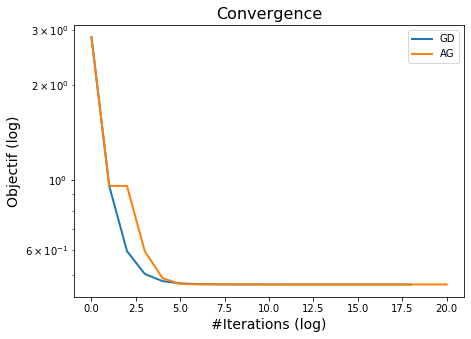

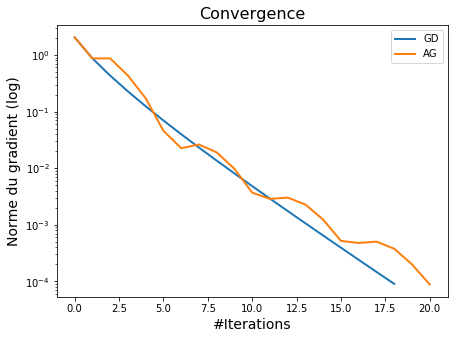

In [ ]:
# Affichage de la comparaison entre les deux méthodes

# En termes de valeurs de l'objectif (échelle logarithmique sur les deux axes)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_gd, label="GD", lw=2)
plt.semilogy(obj_agd, label="AG", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#Iterations (log)", fontsize=14)
plt.ylabel("Objectif (log)", fontsize=14)
plt.legend()
# En termes de norme de gradient (échelle logarithmique sur l'axe des ordonnées)
plt.figure(figsize=(7, 5))
plt.semilogy(ngrad_gd, label="GD", lw=2)
plt.semilogy(ngrad_agd , label="AG", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Norme du gradient (log)", fontsize=14)
plt.legend()

**Question 9:** *Même si le schéma avec $\beta_k$ est valide en théorie (il converge avec la meilleur vitesse de convergence possible, pour des fonctions fortement convexes, on peut faire mieux en choisissant pour $\beta_k$ la valeur constante suivante :*

$$
    \beta_k = \frac{\sqrt{L}-\sqrt{\mu}}{\sqrt{L}+\sqrt{\mu}},
$$

*avec $\mu$ la constante de convexité forte de la fonction objectif (on notera que cette expression est définie pour $\mu=0$).*

*En utilisant la fonction* cvxval() *de la classe* LinReg*, modifier l'algorithme du gradient accéléré pour utiliser cette valeur, et comparer la nouvelle méthode avec la descente de gradient en utilisant les scripts ci-dessous.*

In [ ]:
# Script de test des deux méthodes

w0 = np.zeros(d)
w_gd, obj_gd, ngrad_gd = grad_desc(w0,pblinreg,stepchoice=0,step0=1, n_iter=100,tol_grad=0.0001)
z_agd, obj_agd, ngrad_agd = accel_grad(w0,pblinreg, n_iter=100,tol_grad=0.0001,betcst=True) # beta_k constant

Descente de gradient :
  iter   |   fval   |  normg  
       0 | 2.84e+00 | 2.04e+00
       1 | 9.58e-01 | 8.69e-01
       2 | 5.95e-01 | 4.32e-01
       3 | 5.03e-01 | 2.27e-01
       4 | 4.77e-01 | 1.24e-01
       5 | 4.70e-01 | 6.96e-02
       6 | 4.67e-01 | 3.98e-02
       7 | 4.66e-01 | 2.32e-02
       8 | 4.66e-01 | 1.36e-02
       9 | 4.66e-01 | 8.08e-03
      10 | 4.66e-01 | 4.83e-03
      11 | 4.66e-01 | 2.90e-03
      12 | 4.66e-01 | 1.75e-03
      13 | 4.66e-01 | 1.06e-03
      14 | 4.66e-01 | 6.47e-04
      15 | 4.66e-01 | 3.94e-04
      16 | 4.66e-01 | 2.41e-04
      17 | 4.66e-01 | 1.48e-04
      18 | 4.66e-01 | 9.06e-05
Gradient Accelere :
  iter   |   fval   |  normg  
       0 | 2.84e+00 | 2.04e+00
       1 | 7.47e-01 | 6.49e-01
       2 | 5.02e-01 | 2.20e-01
       3 | 4.71e-01 | 8.06e-02
       4 | 4.67e-01 | 3.11e-02
       5 | 4.66e-01 | 1.22e-02
       6 | 4.66e-01 | 4.84e-03
       7 | 4.66e-01 | 1.91e-03
       8 | 4.66e-01 | 7.47e-04
       9 | 4.66e-01 | 2.92e

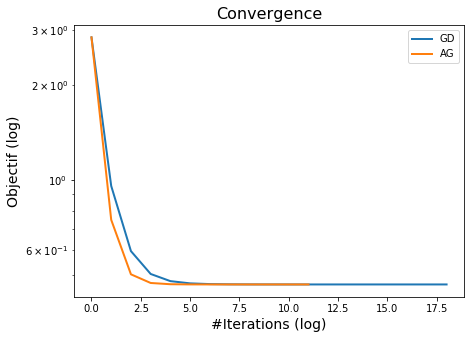

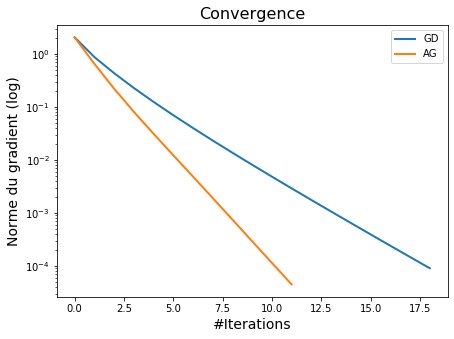

In [ ]:
# Affichage de la comparaison entre les deux méthodes

# En termes de valeurs de l'objectif (échelle logarithmique sur les deux axes)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_gd, label="GD", lw=2)
plt.semilogy(obj_agd, label="AG", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#Iterations (log)", fontsize=14)
plt.ylabel("Objectif (log)", fontsize=14)
plt.legend()
# En termes de norme de gradient (échelle logarithmique sur l'axe des ordonnées)
plt.figure(figsize=(7, 5))
plt.semilogy(ngrad_gd, label="GD", lw=2)
plt.semilogy(ngrad_agd , label="AG", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Norme du gradient (log)", fontsize=14)
plt.legend()

### Questions supplémentaires sur le gradient accéléré

**Question 10 :** *Comparer l'algorithme du gradient accéléré et l'algorithme de descente de gradient en termes de stockage et d'opérations arithmétiques.* 

**Réponse 10 :** La méthode du gradient accéléré doit stocker un vecteur de taille $n$ de plus que la méthode de descente de gradient, mais, comme cette dernière, elle n'effectue qu'un calcul de gradient par itération.

**Question 11 :** *Le résultat de la question 7 devrait montrer que l'appellation* descente de gradient accélérée *(que l'on utilise parfois pour désigner la méthode de Nesterov) est trompeuse. Il est en effet possible que la valeur de l'objectif ne soit pas réduite d'une itération à l'autre. Si l'on suppose que $w_k-w_{k-1}$ est une direction de décroissance pour $f$, comment expliquer que ce phénomène se produise à l'itération $k$ ?* 

**Réponse 11 :** Lorsque $w_k-w_{k-1}$ est une direction de décroissance pour $f$, on peut supposer que cette direction reste une direction de décroissance pour l'itéré suivant, mais cela n'est pas nécessairement le cas. Cependant, lorsque les itérés sont relativement proches, cela sera le cas, et la combinaison de la direction opposée au gradient et de ce terme de momentum conduira à une convergence plus rapide.

## IV) Méthodes de gradient stochastique

Dans cette partie, nous allons exploiter la structure de $f$. On a en effet

$$
f(w) = \tfrac{1}{n} \sum_{i=1}^n f_i(w), \quad f_i(w) = \tfrac{1}{2}\,(x_i^T w - y_i)^2.
$$

ce qui va permettre d'appliquer l'algorithme du gradient stochastique. 




### IV-A) Gradient stochastique

L'itération du gradient stochastique (parfois appelé *SGD*, pour *Stochastic Gradient Descent*) est donnée par

$$
    w_{k+1} = w_k - \alpha_k \nabla f_{i_k}(w_k),
$$

où $i_k$ est tiré aléatoirement dans $\{1,\dots,n\}$ (dans ce notebook, on le tirera de manière uniforme).

Pour tout $i=1,\dots,n$, on notera que le gradient de $f_i$ est $\nabla f_i(w) = x_i (x_i^T w - y_i)$.

**Question 12 :** *Implémenter l'algorithme du gradient stochastique avec $\alpha_k=\tfrac{1}{L}$ et
$\alpha_k=\frac{\alpha_0}{\sqrt{k+1}}$. Comparer les résultats avec ceux de la descente de gradient.*

In [ ]:
# Algorithme du gradient stochastique
def stoch_grad(w0,problem,stepchoice=0,step0=1, n_iter=1000,tol_grad=0.001,nb=1): 
    """
        Gradient stochastique avec différents choix de pas.
        
        Entrées :
            w0: Point initial
            problem: Problème étudié (instance d'une classe Python)
            stepchoice: Choix de calcul de la taille de pas (voir plus haut)
                0: Taille de pas constante en 1/L
                1: Taille de pas décroissante en 1/sqrt(k+1)
            step0: Taille de pas initiale (à utiliser lorsque stepchoice>0)
            n_iter: Nombre maximum d'itérations à effectuer
            tol_grad: Tolérance pour la norme du gradient, utilisée comme critère d'arrêt
            nb: Nombre d'indices tirés à chaque itération (utilisé pour la partie IV-B)
            
        Sorties :
            w_output: Dernier itéré calculé par l'algorithme
            objvals: Historique des valeurs de fonction (tableau Numpy de longueur au plus n_iter)
            normgrads: Historique des normes du gradient (tableau Numpy de longueur au plus n_iter)
    """
    
    ############
    # Calcul et affichage de quantités initiales

    # Historique des valeurs de fonctions
    objvals = []
    # Historique des normes de gradient
    normgrads = []
    
    # Constante de Lipschitz
    L = problem.lipgrad()
    
    # Taille de l'échantillon
    n = problem.n
    
    # Valeur initiale de l'itéré (le .copy() permet de ne pas modifier le point de départ)  
    w = w0.copy()
    nw = norm(w) # Calcul de la norme pour mesurer la divergence

    # Initialisation de l'indice d'itération
    k=0
    
    # Calcul de l'objectif en le point courant+ajout à l'historique
    obj = problem.fun(w) 
    objvals.append(obj);
    # Calcul de la norme du gradient en le point courant
    g = problem.grad(w)
    ng = norm(g)
    normgrads.append(ng)

    # Initialisation de l'indice d'itération
    k=0
    
    # Affichage des valeurs initiales
    print("Gradient Stochastique :")
    print(' | '.join([name.center(8) for name in ["iter", "fval", "normg"]]))
    
    print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ng).rjust(8)]))
    
    ###############
    # Boucle principale
    while (k < n_iter and ng>tol_grad and nw < 10**100):
        # Cette version inclut les variantes "batch" (voir la partie IV-B)
        if nb>1:
            ik = np.random.choice(n,nb,replace=False)# Variante batch
        else:
            ik = np.random.choice(n,nb,replace=True) # Gradient stochastique (1 indice)
        # Calcul du gradient stochastique    
        sg = np.zeros(d)
        for j in range(nb):
            gi = problem.grad_i(ik[j],w)
            sg = sg + gi
        sg = (1/nb)*sg
        # Pas (en fonction du choix de taille de pas)
        if stepchoice==0:
            w[:] = w - (1/L) * sg
        elif stepchoice==1:
            sk = float(step0/(sqrt(k+1)))
            w[:] = w - sk * sg
        nw = norm(w) #Calcul de la norme pour évaluer la divergence de la méthode
        obj = problem.fun(w)
        g = problem.grad(w)
        ng = norm(g)
        k += 1
        # Affichage de l'information du problème toutes les n itérations
        if (k*nb) % n == 0:
            objvals.append(obj)
            normgrads.append(ng)
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ng).rjust(8)]))       
    
    # Affichage de l'itéré final (si pas affiché avant)
    if (k*nb) % n > 0:
        objvals.append(obj)
        normgrads.append(ng)
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ng).rjust(8)]))              
    
    w_output = w.copy()
          
    return w_output, np.array(objvals), np.array(normgrads)

**Question 13 :** *Quel est le coût d'une itération de gradient stochastique par rapport à celui d'une itération de descente de gradient ? Comment quantifier le budget alloué à chaque méthode pour que la comparaison entre les deux soit juste ?*

**Réponse 13 :** **FONDAMENTAL: En termes d'évaluations de $\nabla f_i$, une itération du gradient stochastique est $n$ fois moins chère qu'une itération de descente de gradient.** Sachant cela, une comparaison entre les deux méthodes ne peut s'effectuer en termes d'itérations, mais plutôt en termes de calculs de $\nabla f_i$ : on utilise donc la notion d'*epoch*, qui représente $n$ calculs de $\nabla f_i$ (soit $n$ itérations de gradient stochastique et une itération de descente de gradient).

**Question 14 :** *En se basant sur la réponse à la question 12, comparer les variantes de la descente de gradient et du gradient stochastique the variants of gradient descent and stochastic gradient à l'aide des scripts ci-dessous.*   

**14-a)** *La variante du gradient stochastique utilisée dans le premier bloc devrait diverger. Pourquoi n'est-ce pas une surprise ?*

**Réponse 14-a) :** Le gradient stochastique est une méthode aléatoire (ou "randomisée"), et ne possède donc pas de garanties de convergence déterministes (on peut cependant prouver que la méthode converge dans un sens probabiliste).

**14-b)** *A contrario, comment expliquer la performance de la méthode du gradient stochastique avec une taille de pas décroissante ?*

**Réponse 14-b) :** Quand il n'est pas nécessaire d'utiliser tous les termes de la somme finie définissant $f$ pour faire décroître la valeur de l'objectif, le gradient stochastique peut se révéler extrêmement efficace comparé à la descente de gradient (car beaucoup moins coûteux par itération). Sur le problème que nous étudions ici, les différents exemples du jeu de données sont corrélés, et il est donc possible de générer de bons pas en utilisant uniquement un exemple à la fois (ici, utiliser $n$ examples tirés avec remise est même meilleur qu'utiliser les $n$ exemples disponibles).

In [ ]:
# Comparaison du gradient stochastique et de la descente de gradient
# Le budget alloué à chaque solveur n'est pas le même


nb_epochs = 30
n = pblinreg.n

nbset = 1

w0 = np.zeros(d)
w_a, obj_a, ngrad_a = grad_desc(w0,pblinreg,stepchoice=0,step0=1, n_iter=nb_epochs,tol_grad=0.00001)
# La version ci-dessous diverge - On a ajouté une condition norm(w) dans le code pour que cet arrêt soit contrôlé
w_b, obj_b, ngrad_b = stoch_grad(w0,pblinreg,stepchoice=0,step0=1, n_iter=int(nb_epochs*n/nbset),tol_grad=0.001,nb=nbset)



Descente de gradient :
  iter   |   fval   |  normg  
       0 | 2.84e+00 | 2.04e+00
       1 | 9.58e-01 | 8.69e-01
       2 | 5.95e-01 | 4.32e-01
       3 | 5.03e-01 | 2.27e-01
       4 | 4.77e-01 | 1.24e-01
       5 | 4.70e-01 | 6.96e-02
       6 | 4.67e-01 | 3.98e-02
       7 | 4.66e-01 | 2.32e-02
       8 | 4.66e-01 | 1.36e-02
       9 | 4.66e-01 | 8.08e-03
      10 | 4.66e-01 | 4.83e-03
      11 | 4.66e-01 | 2.90e-03
      12 | 4.66e-01 | 1.75e-03
      13 | 4.66e-01 | 1.06e-03
      14 | 4.66e-01 | 6.47e-04
      15 | 4.66e-01 | 3.94e-04
      16 | 4.66e-01 | 2.41e-04
      17 | 4.66e-01 | 1.48e-04
      18 | 4.66e-01 | 9.06e-05
      19 | 4.66e-01 | 5.57e-05
      20 | 4.66e-01 | 3.43e-05
      21 | 4.66e-01 | 2.11e-05
      22 | 4.66e-01 | 1.30e-05
      23 | 4.66e-01 | 8.05e-06
Gradient Stochastique :
  iter   |   fval   |  normg  
       0 | 2.84e+00 | 2.04e+00
     218 | 9.91e+199 | 1.46e+100


In [ ]:
# Comparaison du gradient stochastique et de la descente de gradient
# Le budget alloué à chaque solveur n'est pas le même et est pensé en termes d'epoch

nb_epochs = 100
n = pblinreg.n

nbset = 1

w_c, obj_c, ngrad_c = grad_desc(w0,pblinreg,stepchoice=1,step0=0.2, n_iter=nb_epochs,tol_grad=0.0001)
w_d, obj_d, ngrad_d = stoch_grad(w0,pblinreg,stepchoice=1,step0=0.2, n_iter=int(nb_epochs*n/nbset),tol_grad=0.0001,nb=nbset)


Descente de gradient :
  iter   |   fval   |  normg  
       0 | 2.84e+00 | 2.04e+00
       1 | 2.08e+00 | 1.66e+00
       2 | 1.82e+00 | 1.51e+00
       3 | 1.67e+00 | 1.42e+00
       4 | 1.57e+00 | 1.36e+00
       5 | 1.50e+00 | 1.31e+00
       6 | 1.44e+00 | 1.27e+00
       7 | 1.40e+00 | 1.24e+00
       8 | 1.36e+00 | 1.21e+00
       9 | 1.32e+00 | 1.19e+00
      10 | 1.30e+00 | 1.17e+00
      11 | 1.27e+00 | 1.15e+00
      12 | 1.25e+00 | 1.13e+00
      13 | 1.23e+00 | 1.12e+00
      14 | 1.21e+00 | 1.11e+00
      15 | 1.20e+00 | 1.09e+00
      16 | 1.18e+00 | 1.08e+00
      17 | 1.17e+00 | 1.07e+00
      18 | 1.16e+00 | 1.06e+00
      19 | 1.14e+00 | 1.05e+00
      20 | 1.13e+00 | 1.04e+00
      21 | 1.12e+00 | 1.03e+00
      22 | 1.11e+00 | 1.02e+00
      23 | 1.10e+00 | 1.02e+00
      24 | 1.09e+00 | 1.01e+00
      25 | 1.09e+00 | 1.00e+00
      26 | 1.08e+00 | 9.97e-01
      27 | 1.07e+00 | 9.90e-01
      28 | 1.06e+00 | 9.84e-01
      29 | 1.06e+00 | 9.78e-01
      30 | 1.05e

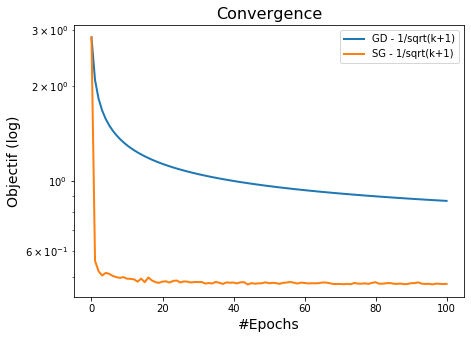

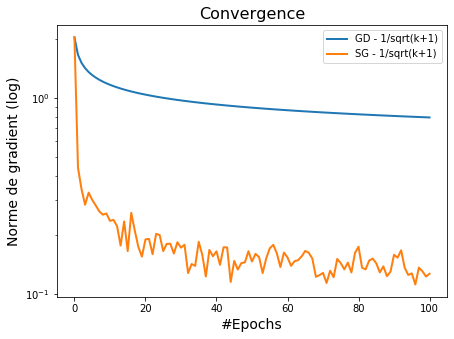

In [ ]:
# Affichage des variantes de GD/SG basées sur un même choix de taille de pas
# NB : L'axe des abscisses est exprimé en "epochs" (n calculs de gradient de f_i).

# En termes de valeurs d'objectif (échelle logarithmique sur l'axe des ordonnées)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_c, label="GD - 1/sqrt(k+1)", lw=2)
plt.semilogy(obj_d, label="SG - 1/sqrt(k+1)", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#Epochs", fontsize=14)
plt.ylabel("Objectif (log)", fontsize=14)
plt.legend()
# En termes de norme de gradient (échelle logarithmique sur l'axe des ordonnées)
plt.figure(figsize=(7, 5))
plt.semilogy(ngrad_c, label="GD - 1/sqrt(k+1)", lw=2)
plt.semilogy(ngrad_d , label="SG - 1/sqrt(k+1)", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#Epochs", fontsize=14)
plt.ylabel("Norme de gradient (log)", fontsize=14)
plt.legend()

### IV-B) Variantes par lots ("batch") du gradient stochastique



**Question 15 :** *Modifier l'implémentation du gradient stochastique de sorte à pouvoir tirer un nombre $n_b$ d'indices uniformément au hasard à chaque itération. Comparer ensuite la performance de ces stratégies à l'aide des scripts ci-dessous en utilisant une taille de pas décroissante.*  
*On suggère ici les valeurs $n_b \in \{1,\tfrac{n}{10},\tfrac{n}{100},\tfrac{n}{2},n\}$ qui incluent le gradient stochastique ($n_b=1$) et la descente de gradient ($n_b=n$).*

*N.B. La fonction* np.random.choice(n,nb,replace=False) *permet de tirer $n_b$ indices uniformément au hasard dans $\{0,\dots,n-1\}$*.

In [ ]:
# Comparaison des implémentations de gradient stochastique avec "batch"
# Le budget en itérations de chaque variante est différent.

nb_epochs = 100
n = pblinreg.n
w0 = np.zeros(d)

w_a, obj_a, ngrad_a = grad_desc(w0,pblinreg,stepchoice=1,step0=0.2, n_iter=nb_epochs,tol_grad=0.0001)
nbset = 1
w_b, obj_b, ngrad_b = stoch_grad(w0,pblinreg,stepchoice=1,step0=0.2, n_iter=int(nb_epochs*n/nbset),tol_grad=0.0001,nb=nbset)
nbset = int(n/100)
w_c, obj_c, ngrad_c = stoch_grad(w0,pblinreg,stepchoice=1,step0=0.2, n_iter=int(nb_epochs*n/nbset),tol_grad=0.0001,nb=nbset)
nbset = int(n/10)
w_d, obj_d, ngrad_d = stoch_grad(w0,pblinreg,stepchoice=1,step0=0.2, n_iter=int(nb_epochs*n/nbset),tol_grad=0.0001,nb=nbset)
nbset = int(n/2)
w_e, obj_e, ngrad_e = stoch_grad(w0,pblinreg,stepchoice=1,step0=0.2, n_iter=int(nb_epochs*n/nbset),tol_grad=0.0001,nb=nbset)

Descente de gradient :
  iter   |   fval   |  normg  
       0 | 2.84e+00 | 2.04e+00
       1 | 2.08e+00 | 1.66e+00
       2 | 1.82e+00 | 1.51e+00
       3 | 1.67e+00 | 1.42e+00
       4 | 1.57e+00 | 1.36e+00
       5 | 1.50e+00 | 1.31e+00
       6 | 1.44e+00 | 1.27e+00
       7 | 1.40e+00 | 1.24e+00
       8 | 1.36e+00 | 1.21e+00
       9 | 1.32e+00 | 1.19e+00
      10 | 1.30e+00 | 1.17e+00
      11 | 1.27e+00 | 1.15e+00
      12 | 1.25e+00 | 1.13e+00
      13 | 1.23e+00 | 1.12e+00
      14 | 1.21e+00 | 1.11e+00
      15 | 1.20e+00 | 1.09e+00
      16 | 1.18e+00 | 1.08e+00
      17 | 1.17e+00 | 1.07e+00
      18 | 1.16e+00 | 1.06e+00
      19 | 1.14e+00 | 1.05e+00
      20 | 1.13e+00 | 1.04e+00
      21 | 1.12e+00 | 1.03e+00
      22 | 1.11e+00 | 1.02e+00
      23 | 1.10e+00 | 1.02e+00
      24 | 1.09e+00 | 1.01e+00
      25 | 1.09e+00 | 1.00e+00
      26 | 1.08e+00 | 9.97e-01
      27 | 1.07e+00 | 9.90e-01
      28 | 1.06e+00 | 9.84e-01
      29 | 1.06e+00 | 9.78e-01
      30 | 1.05e

    6300 | 4.69e-01 | 8.12e-02
    6400 | 4.69e-01 | 8.56e-02
    6500 | 4.69e-01 | 8.49e-02
    6600 | 4.69e-01 | 8.07e-02
    6700 | 4.69e-01 | 7.92e-02
    6800 | 4.69e-01 | 8.32e-02
    6900 | 4.69e-01 | 8.21e-02
    7000 | 4.69e-01 | 9.06e-02
    7100 | 4.69e-01 | 8.00e-02
    7200 | 4.68e-01 | 6.44e-02
    7300 | 4.69e-01 | 7.90e-02
    7400 | 4.69e-01 | 7.80e-02
    7500 | 4.69e-01 | 7.87e-02
    7600 | 4.68e-01 | 6.95e-02
    7700 | 4.69e-01 | 7.74e-02
    7800 | 4.68e-01 | 6.85e-02
    7900 | 4.68e-01 | 5.91e-02
    8000 | 4.68e-01 | 6.03e-02
    8100 | 4.68e-01 | 6.58e-02
    8200 | 4.68e-01 | 6.83e-02
    8300 | 4.69e-01 | 7.98e-02
    8400 | 4.69e-01 | 8.12e-02
    8500 | 4.68e-01 | 6.92e-02
    8600 | 4.69e-01 | 8.47e-02
    8700 | 4.70e-01 | 1.01e-01
    8800 | 4.70e-01 | 9.56e-02
    8900 | 4.70e-01 | 9.38e-02
    9000 | 4.70e-01 | 8.89e-02
    9100 | 4.70e-01 | 8.69e-02
    9200 | 4.69e-01 | 8.04e-02
    9300 | 4.69e-01 | 7.27e-02
    9400 | 4.69e-01 | 7.63e-02
    9500

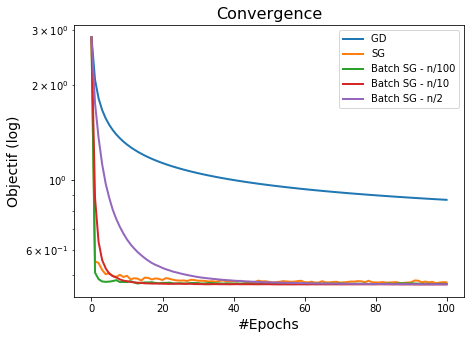

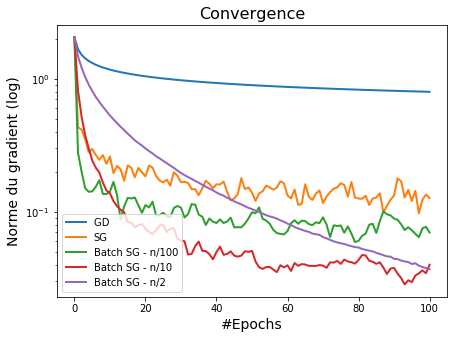

In [ ]:
# Affichage de la comparaison des variantes "batch" avec le même choix pour la taille de pas

# En termes d'objectif (échelle logarithmique sur l'axe des ordonnées)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a, label="GD ", lw=2)
plt.semilogy(obj_b, label="SG", lw=2)
plt.semilogy(obj_c, label="Batch SG - n/100", lw=2)
plt.semilogy(obj_d, label="Batch SG - n/10", lw=2)
plt.semilogy(obj_e, label="Batch SG - n/2", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#Epochs", fontsize=14)
plt.ylabel("Objectif (log)", fontsize=14)
plt.legend()
# En termes de norme du gradient (échelle logarithmique sur l'axe des ordonnées)
plt.figure(figsize=(7, 5))
plt.semilogy(ngrad_a, label="GD ", lw=2)
plt.semilogy(ngrad_b, label="SG", lw=2)
plt.semilogy(ngrad_c, label="Batch SG - n/100", lw=2)
plt.semilogy(ngrad_d, label="Batch SG - n/10", lw=2)
plt.semilogy(ngrad_e, label="Batch SG - n/2", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#Epochs", fontsize=14)
plt.ylabel("Norme du gradient (log)", fontsize=14)
plt.legend()

### Question complémentaire sur les méthodes de gradient stochastique

**Question 16 :** *En termes d'implémentation, quelle propriété des méthodes "batch" (non utilisée ici) peut être exploitée pour effectuer les calculs de manière plus efficace ?*

**Réponse 16 :** Les différents gradients des $f_i$ calculés lors d'une itération d'une méthode "batch" peuvent être évalués en parallèle dès lors que l'architecture logicielle sur laquelle est exécutée la méthode le permet.

## V) Régularisation

Dans cette dernière partie, nous allons introduire des termes de régularisation (lisse et non lisse) dans notre problème.

### V-A) Régularisation en norme $\ell_2$

On considère le problème
$$
    \min_{w \in \mathbb{R}^d} f_{\ell_2}(w) = \frac{1}{2n} \|X w - y\|^2 + \frac{\lambda}{2} \|w\|^2,
$$
appelé problème de régularisation écrêtée, ou *ridge regression*.

On donne le gradient de $f_{\ell_2}$ :

$$
\nabla f_{\ell_2}(w) = \tfrac{X^T X+ \lambda n I}{n} w -X^T y. 
$$

**Question 17 :** *Quel est le but derrière l'introduction du terme $\frac{\lambda}{2} \|w\|^2$?*

**Réponse 17 :** Il existe différentes interprétations dans le contexte de la régression linéaire, qui sont toutes valides :

1) En termes d'algèbre linéaire, la régularisation transforme le systme $X^T X w = X^T y$ en un autre système qui possède une unique solution lorsque la valeur de $\lambda$ est suffisamment grande;

2) Pour $\lambda>0$, l'objectif du problème d'optimisation est fortement convexe, et possède un unique minimum global;

3) Ce terme de régularisation permet de réduire la variance de la solution relativement aux données;

4) Ce terme de régularisation impose implictement une contrainte sur la norme $\ell_2$ de la solution.

On définit ci-dessous une nouvelle classe Python correspondant aux problèmes de régression écrêtée (NB : pour ce TP, on utilisera une nouvelle classe, même si une implémentation plus générique serait envisageable).

In [ ]:
from scipy.linalg import svdvals #Décomposition en valeurs singulières

# Classe Python pour les problèmes de régression écrêtée
class RidgeReg(object):
   

    def __init__(self, X, y,lbda):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.lbda = lbda
    
    # Fonction objectif
    def fun(self, w):
        return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(w) ** 2 / 2.
    
    # Gradient complet
    def grad(self, w):
        return self.X.T.dot(self.X.dot(w) - self.y) / self.n + self.lbda * w

    # Gradient partiel
    def grad_i(self, i, w):
        x_i = self.X[i]
        return (x_i.dot(w) - self.y[i]) * x_i + self.lbda * w

    # Constante de Lipschitz pour le gradient
    def lipgrad(self):
        L = norm(self.X, ord=2) ** 2 / self.n + self.lbda
        return L
    
    # Constante de convexité forte
    def cvxval(self):
        s = svdvals(self.X)
        mu = self.lbda + min(s)**2 / self.n
        return mu

**Question 18 :** *Comparer la performance de la descente de gradient et du gradient accéléré sur ce nouveau problème, avec $\lambda \in \{0.1, 100\}$. Les résultats sont-ils cohérents avec la théorie ?*

**Réponse 18 :** On observe que les deux méthodes sont plus similaires lorsque $\lambda$ augment, car la fonction devient proche d'une quadratique avec minimum en $0$.

In [ ]:
# Définition du problème (deux valeurs à tester)
#lbda = 0.1
lbda = 100

pb_ridgereg = RidgeReg(X, y,lbda)

In [ ]:
# Comparaison de la descente de gradient et du gradient accéléré

w0 = np.zeros(d)
w_gd, obj_gd, ngrad_gd = grad_desc(w0,pb_ridgereg,stepchoice=0,step0=1, n_iter=100,tol_grad=0.0001)
z_sg, obj_ag, ngrad_ag = accel_grad(w0,pb_ridgereg,n_iter=100,tol_grad=0.0001,betcst=True)

Descente de gradient :
  iter   |   fval   |  normg  
       0 | 2.84e+00 | 2.04e+00
       1 | 2.82e+00 | 1.32e-02
       2 | 2.82e+00 | 1.00e-04
       3 | 2.82e+00 | 8.03e-07
Gradient Accelere :
  iter   |   fval   |  normg  
       0 | 2.84e+00 | 2.04e+00
       1 | 2.82e+00 | 8.91e-03
       2 | 2.82e+00 | 3.97e-05


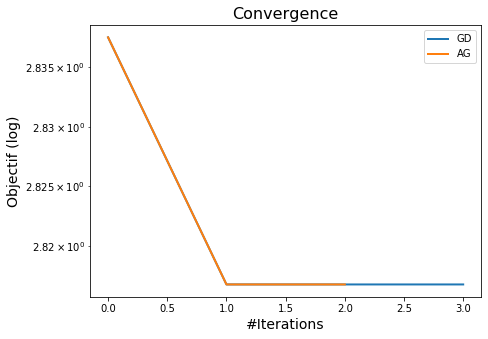

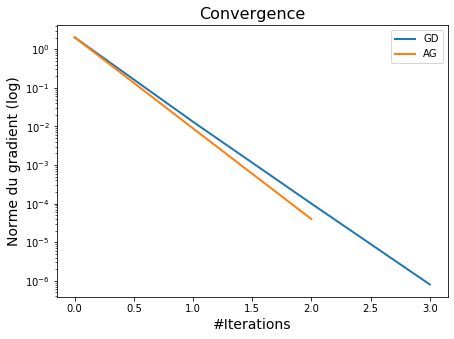

In [ ]:
# Affichage de la comparaison

# En termes de fonction objectif (échelle logarithmique sur l'axe des ordonnées)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_gd, label="GD", lw=2)
plt.semilogy(obj_ag, label="AG", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objectif (log)", fontsize=14)
plt.legend()
# En termes de norme de gradient (échelle logarithmique sur l'axe des ordonnées)
plt.figure(figsize=(7, 5))
plt.semilogy(ngrad_gd, label="GD", lw=2)
plt.semilogy(ngrad_ag, label="AG", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Norme du gradient (log)", fontsize=14)
plt.legend()

### V-B) Régularisation en norme $\ell_1$

On considère maintenant la norme $\ell_1$ définie par $\|w\|_1 := \sum_{i=1}^d |w_i|$ et le problème

$$
    \min_{w \in \mathbb{R}^d} f_{\ell_1}(w) = \frac{1}{2n} \|X w - y\|^2 + \lambda \|w\|_1,
$$

appelé problème *LASSO*.

**Question 19 :** *Pourquoi ne peut-on pas appliquer l'algorithme de descente de gradient directement à ce problème ?*

**Réponse 19 :** La fonction $f_{\ell_1}$ n'est pas dérivable en tout point de $\mathbb{R}^d$.

In [ ]:
from scipy.linalg import svdvals # Décomposition en valeurs singulières (pour que cette partie soit indépendante)

# Classe Python pour les problèmes de régression LASSO 
class LassoReg(object):
   

    def __init__(self, X, y,lbda):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.lbda = lbda
    
    # Fonction objectif
    def fun(self, w):
        return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n)
    
    # Fonction objectif régularisée
    def funreg(self,w):
        return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(w,1)
    
    # Gradient pour la partie lisse du problème
    def grad(self, w):
        return self.X.T.dot(self.X.dot(w) - self.y) / self.n

    # Gradient partiel pour la partie lisse du problème
    def grad_i(self, i, w):
        x_i = self.X[i]
        return (x_i.dot(w) - self.y[i]) * x_i 

    # Constante de Lipschitz pour le gradient de la partie lisse du problème
    def lipgrad(self):
        L = norm(self.X, ord=2) ** 2 / self.n 
        return L
    
    # Paramètre de convexité forte pour la partie lisse du problème
    def cvxval(self):
        s = svdvals(self.X)
        mu = min(s)**2 / self.n
        return mu

Pour résoudre ce problème, on peut appliquer l'algorithme ISTA *(Iterative Soft-Thresholding Algorithm)* dont on rappelle le fonctionnement ci-après : étant donnés un itéré $w_k$ et une taille de aps $\alpha_k$, la méthode calcule tout d'abord le vecteur
$$
    g_k = w_k - \alpha_k \nabla f(w_k),
$$
où $f$ est la partie lisse de $f_{\ell_1}$, avec $f_{\ell_1}(w) = f(w) + \lambda \|w\|_1$.

L'itéré suivant $w_{k+1}$ est ensuite défini par composante comme suit :

$$
    \forall i=1,\dots,d, \quad [w_{k+1}]_i \; = \; 
    \left\{
        \begin{array}{ll}
            [g_k]_i + \lambda \alpha_k &\mathrm{if} [g_k]_i < -\lambda \alpha_k \\
            [g_k]_i - \lambda \alpha_k &\mathrm{if} [g_k]_i > \lambda \alpha_k \\
            0 &\mathrm{otherwise.}
        \end{array}
    \right.
$$

**Question 20 :** *Compléter le code ci-dessous pour implémenter l'algorithme ISTA avec tailles de pas constante et décroissante.*

In [ ]:
# Implémentation de l'algorithme ISTA
def ista(w0,problem,stepchoice=0,step0=1, n_iter=1000,tol_grad=0.001): 
    """
        Code pour ISTA avec différents choix de tailles de pas
        
        Entrées :
            w0: Point initial
            problem: Problème étudié (instance d'une classe Python)
            stepchoice: Choix de calcul de la taille de pas (voir plus haut)
                0: Taille de pas constante égal à 1/L
                1: Taille de pas décroissante en 1/(k+1)
                2: Taille de pas décroissante en 1/sqrt(k+1)
            step0: Taille de pas initiale (à utiliser lorsque stepchoice>0)
            n_iter: Nombre maximum d'itérations à effectuer
            tol_grad: Tolérance pour la norme du gradient, utilisée comme critère d'arrêt
            
        Sorties :
            w_output: Dernier itéré calculé par l'algorithme
            objvals: Historique des valeurs de fonction (tableau Numpy de longueur au plus n_iter)
            normgrads: Historique des normes du gradient (tableau Numpy de longueur au plus n_iter)
    """    
        
    ############
    # Pas initial : Calculer et affichage de quantités initiales

    # Historique des valeurs de fonction
    objvals = []
    # Historique des normes de gradient
    normgrads = []
    
    # Constante de Lipschitz
    L = problem.lipgrad()
    
    # Paramètre de régularisaton
    lbda = problem.lbda
    
    # Valeur initiale de l'itéré (le .copy() permet de ne pas modifier le point de départ)  
    w = w0.copy()

    # Initialisation de l'indice d'itération
    k=0    
    
    # Calcul de la fonction objectif en le point initial + ajout à l'historique
    obj = problem.fun(w) 
    objvals.append(obj);
    # Calcul de la norme du gradient en le point initial + ajout à l'historique
    g = problem.grad(w)
    ng = norm(g)
    normgrads.append(ng)

    k=0
    step=step0
    threshold = 0
    
    # Affichage des valeurs initiales
    print("ISTA :")
    print(' | '.join([name.center(8) for name in ["iter", "fval", "normg"]]))
    
    print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ng).rjust(8)]))
    
    ############
    # Boucle principale
    while (k < n_iter and normgrads[k]>tol_grad):
        # Calcul de la nouvelle taille de pas
        if stepchoice==0:
            step = 1/L
        elif (stepchoice==1):
            step = step0/(k+1)
        else:
            step = step0/(sqrt(k+1))
        
        # Calcul du nouvel itéré par composantes
        for i in range(problem.d):
            vali = w[i]-step*g[i]
            threshold = step*lbda
            if vali < -threshold:
                #w_new[i] = vali+threshold
                w[i] = vali+threshold
            elif vali > threshold:
                #w_new[i] = vali-threshold
                w[i] = vali-threshold
            else:
                #w_new[i] = 0
                w[i] = 0
            
        #w[:] = w_new
        obj = problem.fun(w)
        objvals.append(obj)
        g = problem.grad(w)
        ng = norm(g)
        normgrads.append(ng)
        k += 1
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ng).rjust(8)]))       
        
    
    w_output = w.copy()
          
    return w_output, np.array(objvals), np.array(normgrads)

In [ ]:
# Génération du problème avec une valeur de lambda relativement faible
lbda = 1. / n ** (0.5)

pb_lassoreg = LassoReg(X, y,lbda)

**Question 21 :** *En utilisant les scripts ci-desous, comparer ISTA sur le problème du LASSO avec la descente de gradient sur le problème non régularisé (l'algorithme de la partie II fonctionne sur une instance de type LassoReg), en utilisant le même choix pour la taille de pas.*

**21-a)** *La classe* LassoReg *renvoie le gradient de la partie lisse de la fonction. Que représente ce terme dans le sous-problème d'une méthode proximale ?*

**Réponse 21-a) :** Ce terme est utilisé pour former un modèle linéaire de la partie lisse du problème. En effet, l'itération du gradient proximal (dont ISTA est un cas particulier) s'écrit 
$$
    w_{k+1} = \arg\min_{w \in \mathbb{R}^d} f(w_k) + \nabla f(w_k)^\top (w-w_k) + \frac{1}{2\alpha_k}\|w-w_k\|^2 + \|w\|_1.
$$

**21-b)** *En utilisant la fonction* np.count_nonzero, *on peut calculer le nombre de coefficients non nuls de la solution obtenue. Quelle propriété de la régularisation $\ell_1$ est mise en avant par ces résultats ?*

**Réponse 21-b) :** On retrouve ici le fait que la régularisation $\ell_1$ conduit à des solutions plus 
parcimonieuses.

In [ ]:
# Validation de l'implémentation de l'algorithme ISTA.
w0 = np.ones(d)
w_a, obj_a, ngrad_a = ista(w0,pb_lassoreg,stepchoice=0,step0=1, n_iter=100,tol_grad=0.001)
nnza = np.count_nonzero(w_a)
print('Nombre de coeffs non nuls',nnza)
w_b, obj_b, ngrad_b = ista(w0,pb_lassoreg,stepchoice=1,step0=1, n_iter=100,tol_grad=0.001)
nnzb = np.count_nonzero(w_b)
print('Nombre de coeffs non nuls',nnzb)

w_c, obj_c, ngrad_c = grad_desc(w0,pb_lassoreg,stepchoice=0,step0=1, n_iter=100,tol_grad=0.001)
nnzc = np.count_nonzero(w_c)
print('Nombre de coeffs non nuls',nnzc)
w_d, obj_d, ngrad_d = grad_desc(w0,pb_lassoreg,stepchoice=1,step0=1, n_iter=100,tol_grad=0.001)
nnzd = np.count_nonzero(w_d)
print('Nombre de coeffs non nuls',nnzd)